## Pyspark Dataframe

In [1]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [2]:
from pyspark.sql import SparkSession

In [3]:
spark=(SparkSession.builder.appName('SparkSQL').getOrCreate())

In [4]:
tweet = (spark.read.format('csv')
         .option('inferSchema', 'true')
         .option('header', 'false')
         .load('file:///home/hduser/Downloads/ProjectTweets.csv')
         .toDF('ID', 'ID1', 'Date', 'Flag', 'User', 'Text'))

In [5]:
tweet.show()

+---+----------+--------------------+--------+---------------+--------------------+
| ID|       ID1|                Date|    Flag|           User|                Text|
+---+----------+--------------------+--------+---------------+--------------------+
|  0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|  1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|  2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|  3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|  4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
|  5|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|  6|1467811592|Mon Apr 06 22:20:...|NO_QUERY|        mybirch|         Need a hug |
|  7|1467811594|Mon Apr 06 22:20:...|NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|  8|1467811795|Mon Apr 06 22:20:...|NO_QUERY|2Hood4Hollywood|@Tatiana_K nop

In [6]:
tweet.createOrReplaceTempView('Tweets')

In [7]:
spark.sql('SELECT Date, Text FROM Tweets').show(5)

+--------------------+--------------------+
|                Date|                Text|
+--------------------+--------------------+
|Mon Apr 06 22:19:...|@switchfoot http:...|
|Mon Apr 06 22:19:...|is upset that he ...|
|Mon Apr 06 22:19:...|@Kenichan I dived...|
|Mon Apr 06 22:19:...|my whole body fee...|
|Mon Apr 06 22:19:...|@nationwideclass ...|
+--------------------+--------------------+
only showing top 5 rows



In [8]:
tweet.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- ID1: long (nullable = true)
 |-- Date: string (nullable = true)
 |-- Flag: string (nullable = true)
 |-- User: string (nullable = true)
 |-- Text: string (nullable = true)



In [9]:
from pyspark.sql.functions import lower

tweet = tweet.withColumn("Text", lower(tweet["Text"]))


In [10]:
#pip install --upgrade numpy==1.24.3 

In [11]:
from pyspark.ml.feature import Tokenizer
tokenizer = Tokenizer(inputCol='Text', outputCol='Text1')
tweet = tokenizer.transform(tweet)

In [12]:
from pyspark.ml.feature import StopWordsRemover

remover= StopWordsRemover(inputCol='Text1', outputCol='Text2')
tweet = remover.transform(tweet)

In [13]:
tweet.select("Text", "Text1", 'Text2').show()

+--------------------+--------------------+--------------------+
|                Text|               Text1|               Text2|
+--------------------+--------------------+--------------------+
|@switchfoot http:...|[@switchfoot, htt...|[@switchfoot, htt...|
|is upset that he ...|[is, upset, that,...|[upset, update, f...|
|@kenichan i dived...|[@kenichan, i, di...|[@kenichan, dived...|
|my whole body fee...|[my, whole, body,...|[whole, body, fee...|
|@nationwideclass ...|[@nationwideclass...|[@nationwideclass...|
|@kwesidei not the...|[@kwesidei, not, ...|[@kwesidei, whole...|
|         need a hug |      [need, a, hug]|         [need, hug]|
|@loltrish hey  lo...|[@loltrish, hey, ...|[@loltrish, hey, ...|
|@tatiana_k nope t...|[@tatiana_k, nope...|  [@tatiana_k, nope]|
|@twittera que me ...|[@twittera, que, ...|[@twittera, que, ...|
|spring break in p...|[spring, break, i...|[spring, break, p...|
|i just re-pierced...|[i, just, re-pier...|  [re-pierced, ears]|
|@caregiving i cou...|[@c

In [14]:
from textblob import TextBlob
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
from pyspark.sql.functions import col

def get_sentiment(text):
    text_str = str(text)
    analysis = TextBlob(text_str)
    return analysis.sentiment.polarity

sentiment_udf = udf(get_sentiment, FloatType())
tweet = tweet.withColumn('Sentiment', sentiment_udf('Text1'))

tweet.select('Text1', 'Sentiment').show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------+-----------+
|Text1                                                                                                                                        |Sentiment  |
+---------------------------------------------------------------------------------------------------------------------------------------------+-----------+
|[@switchfoot, http://twitpic.com/2y1zl, -, awww,, that's, a, bummer., , you, shoulda, got, david, carr, of, third, day, to, do, it., ;d]     |0.2        |
|[is, upset, that, he, can't, update, his, facebook, by, texting, it..., and, might, cry, as, a, result, , school, today, also., blah!]       |0.0        |
|[@kenichan, i, dived, many, times, for, the, ball., managed, to, save, 50%, , the, rest, go, out, of, bounds]                                |0.5        |
|[my, whole, body, feels, itchy, and, like, its, on, fire]      

In [15]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/hduser/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [16]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from pyspark.sql.types import StringType

analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    if isinstance(text, list):
        text = ' '.join(map(str, text))
    sentiment = analyzer.polarity_scores(text)
    if sentiment['compound'] > 0.3:
        return 'Positive'
    elif sentiment['compound'] < -0.3:
        return 'Negative'
    else:
        return 'Neutral'
    
sentiment_udf = udf(analyze_sentiment, StringType())

tweet = tweet.withColumn('Polarity', sentiment_udf('Text2'))

tweet.select('Sentiment', 'Polarity').show(truncate=False)

+-----------+--------+
|Sentiment  |Polarity|
+-----------+--------+
|0.2        |Neutral |
|0.0        |Negative|
|0.5        |Positive|
|0.2        |Neutral |
|-0.625     |Negative|
|0.2        |Neutral |
|0.0        |Positive|
|0.27083334 |Positive|
|0.0        |Neutral |
|0.0        |Neutral |
|-0.21428572|Neutral |
|0.0        |Neutral |
|0.0        |Negative|
|0.0        |Neutral |
|0.075      |Negative|
|0.0        |Positive|
|0.0        |Negative|
|0.0        |Neutral |
|0.78125    |Positive|
|0.0        |Neutral |
+-----------+--------+
only showing top 20 rows



In [20]:
from pyspark.ml.feature import CountVectorizer
cv = CountVectorizer(inputCol="Text2", 
                     outputCol="Features", 
                     vocabSize=3, 
                     minDF=1.0)

In [21]:
model = cv.fit(tweet)
result = model.transform(tweet)

In [22]:
result.select("Features").show(truncate=False)

+-------------+
|Features     |
+-------------+
|(3,[0],[1.0])|
|(3,[0],[1.0])|
|(3,[0],[1.0])|
|(3,[],[])    |
|(3,[],[])    |
|(3,[],[])    |
|(3,[],[])    |
|(3,[0],[2.0])|
|(3,[],[])    |
|(3,[],[])    |
|(3,[],[])    |
|(3,[],[])    |
|(3,[0],[1.0])|
|(3,[],[])    |
|(3,[0],[3.0])|
|(3,[0],[1.0])|
|(3,[0],[1.0])|
|(3,[],[])    |
|(3,[0],[1.0])|
|(3,[],[])    |
+-------------+
only showing top 20 rows



In [23]:
from pyspark.ml.feature import HashingTF, IDF, StringIndexer
from pyspark.ml.classification import NaiveBayes
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

label_indexer = StringIndexer(inputCol="User", outputCol="Label_Index").fit(tweet)
df = label_indexer.transform(tweet)

In [24]:
hashingTF = HashingTF(inputCol="Text2", outputCol="Raw_Features", numFeatures=20)
idf = IDF(inputCol="Raw_Features", outputCol="features")
pipeline = Pipeline(stages=[hashingTF, idf])

In [25]:
model = pipeline.fit(df)
df = model.transform(df)

In [26]:
(trainingData, testData) = df.randomSplit([0.8, 0.2], seed=1234)

In [27]:
spark = SparkSession.builder \
    .appName("YourAppName") \
    .config("spark.executor.memory", "2g") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()

In [34]:
nb = NaiveBayes(featuresCol="features", 
                labelCol="Label_Index", 
                predictionCol="prediction", 
                smoothing=1.0, 
                modelType="multinomial")
nb_model = nb.fit(trainingData)

2023-11-15 14:13:00,882 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 20.6 MiB
2023-11-15 14:39:28,600 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 20.5 MiB


In [35]:
spark = SparkSession.builder.config("spark.network.timeout", "600s").getOrCreate()

In [36]:
predictions = nb_model.transform(testData)

In [37]:
evaluator = MulticlassClassificationEvaluator(labelCol="Label_Index", 
                                              predictionCol="prediction", 
                                              metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test set accuracy = {:.2f}%".format(accuracy * 100))

2023-11-15 14:41:29,291 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 116.9 MiB
2023-11-15 14:44:29,863 WARN memory.TaskMemoryManager: Failed to allocate a page (8388608 bytes), try again.
2023-11-15 14:44:30,651 WARN memory.TaskMemoryManager: Failed to allocate a page (8388608 bytes), try again.
2023-11-15 14:44:31,489 WARN memory.TaskMemoryManager: Failed to allocate a page (8388608 bytes), try again.
2023-11-15 14:44:32,059 WARN memory.TaskMemoryManager: Failed to allocate a page (8388608 bytes), try again.
2023-11-15 14:45:43,535 WARN memory.TaskMemoryManager: Failed to allocate a page (8388608 bytes), try again.
2023-11-15 14:45:45,240 WARN memory.TaskMemoryManager: Failed to allocate a page (8388608 bytes), try again.
2023-11-15 14:45:45,832 WARN memory.TaskMemoryManager: Failed to allocate a page (8388608 bytes), try again.
2023-11-15 14:46:15,948 WARN memory.TaskMemoryManager: Failed to allocate a page (8388608 bytes), try again.
2023-11-15 14:47:25,385 

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_25607/3342770626.py", line 4, in <module>
    accuracy = evaluator.evaluate(predictions)
  File "/usr/local/spark/python/pyspark/ml/evaluation.py", line 84, in evaluate
    return self._evaluate(dataset)
  File "/usr/local/spark/python/pyspark/ml/evaluation.py", line 120, in _evaluate
    return self._java_obj.evaluate(dataset._jdf)
  File "/usr/local/spark/python/lib/py4j-0.10.9.5-src.zip/py4j/java_gateway.py", line 1321, in __call__
    return_value = get_return_value(
  File "/usr/local/spark/python/pyspark/sql/utils.py", line 111, in deco
    return f(*a, **kw)
  File "/usr/local/spark/python/lib/py4j-0.10.9.5-src.zip/py4j/protocol.py", line 326, in get_return_value
    raise Py4JJavaError(
py4j.protocol.Py4JJavaError: <unprintable P

ConnectionRefusedError: [Errno 111] Connection refused

## MongoDB

In [29]:
#pip install pymongo_spark

In [39]:
#pip install pyspark

In [40]:
mongo_spark_jar_path = "/home/hduser/Downloads/mongo-spark-connector.jar"

In [46]:
spark = SparkSession.builder \
    .appName("MongoDBSparkConnectorExample") \
    .config("spark.mongodb.input.uri", "mongodb://localhost:27017/twitter.tweet") \
    .config("spark.mongodb.output.uri", "mongodb://localhost:27017/twitter.tweet") \
    .config("spark.jars", mongo_spark_jar_path) \
    .getOrCreate()

In [48]:
tweet.write.format("com.mongodb.spark.sql.DefaultSource").mode("append").save()

Py4JJavaError: An error occurred while calling o415.save.
: java.lang.ClassNotFoundException: 
Failed to find data source: com.mongodb.spark.sql.DefaultSource. Please find packages at
http://spark.apache.org/third-party-projects.html
       
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedToFindDataSourceError(QueryExecutionErrors.scala:443)
	at org.apache.spark.sql.execution.datasources.DataSource$.lookupDataSource(DataSource.scala:670)
	at org.apache.spark.sql.execution.datasources.DataSource$.lookupDataSourceV2(DataSource.scala:720)
	at org.apache.spark.sql.DataFrameWriter.lookupV2Provider(DataFrameWriter.scala:852)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:256)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:247)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: java.lang.ClassNotFoundException: com.mongodb.spark.sql.DefaultSource.DefaultSource
	at java.net.URLClassLoader.findClass(URLClassLoader.java:387)
	at java.lang.ClassLoader.loadClass(ClassLoader.java:418)
	at java.lang.ClassLoader.loadClass(ClassLoader.java:351)
	at org.apache.spark.sql.execution.datasources.DataSource$.$anonfun$lookupDataSource$5(DataSource.scala:656)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.sql.execution.datasources.DataSource$.$anonfun$lookupDataSource$4(DataSource.scala:656)
	at scala.util.Failure.orElse(Try.scala:224)
	at org.apache.spark.sql.execution.datasources.DataSource$.lookupDataSource(DataSource.scala:656)
	... 16 more


In [50]:
import pymongo

In [51]:
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["twitter"]
collection = db["tweet"]

In [52]:
tweet_panda = tweet.toPandas()

2023-11-15 20:26:01,259 ERROR executor.Executor: Exception in task 1.0 in stage 16.0 (TID 21)
java.lang.OutOfMemoryError: Java heap space
	at java.util.Arrays.copyOf(Arrays.java:3236)
	at java.io.ByteArrayOutputStream.grow(ByteArrayOutputStream.java:118)
	at java.io.ByteArrayOutputStream.ensureCapacity(ByteArrayOutputStream.java:93)
	at java.io.ByteArrayOutputStream.write(ByteArrayOutputStream.java:153)
	at org.apache.spark.util.ByteBufferOutputStream.write(ByteBufferOutputStream.scala:41)
	at java.io.ObjectOutputStream$BlockDataOutputStream.drain(ObjectOutputStream.java:1877)
	at java.io.ObjectOutputStream$BlockDataOutputStream.setBlockDataMode(ObjectOutputStream.java:1786)
	at java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1189)
	at java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:348)
	at org.apache.spark.serializer.JavaSerializationStream.writeObject(JavaSerializer.scala:44)
	at org.apache.spark.serializer.JavaSerializerInstance.serialize(JavaSerializ

Py4JJavaError: An error occurred while calling o125.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 16.0 failed 1 times, most recent failure: Lost task 1.0 in stage 16.0 (TID 21) (10.0.2.15 executor driver): java.lang.OutOfMemoryError: Java heap space
	at java.util.Arrays.copyOf(Arrays.java:3236)
	at java.io.ByteArrayOutputStream.grow(ByteArrayOutputStream.java:118)
	at java.io.ByteArrayOutputStream.ensureCapacity(ByteArrayOutputStream.java:93)
	at java.io.ByteArrayOutputStream.write(ByteArrayOutputStream.java:153)
	at org.apache.spark.util.ByteBufferOutputStream.write(ByteBufferOutputStream.scala:41)
	at java.io.ObjectOutputStream$BlockDataOutputStream.drain(ObjectOutputStream.java:1877)
	at java.io.ObjectOutputStream$BlockDataOutputStream.setBlockDataMode(ObjectOutputStream.java:1786)
	at java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1189)
	at java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:348)
	at org.apache.spark.serializer.JavaSerializationStream.writeObject(JavaSerializer.scala:44)
	at org.apache.spark.serializer.JavaSerializerInstance.serialize(JavaSerializer.scala:101)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2450)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2399)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2398)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2398)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1156)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1156)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1156)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2638)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2580)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2569)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:938)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2224)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2245)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2264)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2289)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1030)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1029)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:410)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:3538)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3706)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:775)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3704)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3535)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: java.lang.OutOfMemoryError: Java heap space
	at java.util.Arrays.copyOf(Arrays.java:3236)
	at java.io.ByteArrayOutputStream.grow(ByteArrayOutputStream.java:118)
	at java.io.ByteArrayOutputStream.ensureCapacity(ByteArrayOutputStream.java:93)
	at java.io.ByteArrayOutputStream.write(ByteArrayOutputStream.java:153)
	at org.apache.spark.util.ByteBufferOutputStream.write(ByteBufferOutputStream.scala:41)
	at java.io.ObjectOutputStream$BlockDataOutputStream.drain(ObjectOutputStream.java:1877)
	at java.io.ObjectOutputStream$BlockDataOutputStream.setBlockDataMode(ObjectOutputStream.java:1786)
	at java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1189)
	at java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:348)
	at org.apache.spark.serializer.JavaSerializationStream.writeObject(JavaSerializer.scala:44)
	at org.apache.spark.serializer.JavaSerializerInstance.serialize(JavaSerializer.scala:101)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 51496)
Traceback (most recent call last):
  File "/usr/lib/python3.10/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.10/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.10/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.10/socketserver.py", line 747, in __init__
    self.handle()
  File "/usr/local/spark/python/pyspark/accumulators.py", line 262, in handle
    poll(accum_updates)
  File "/usr/local/spark/python/pyspark/accumulators.py", line 235, in poll
    if func():
  File "/usr/local/spark/python/pyspark/accumulators.py", line 239, in accum_updates
    num_updates = read_int(self.rfile)
  File "/usr/local/spark/python/pyspark/serializers.py",

In [47]:
#df = spark.read.format("com.mongodb.spark.sql.DefaultSource").load()

Py4JJavaError: An error occurred while calling o410.load.
: java.lang.ClassNotFoundException: 
Failed to find data source: com.mongodb.spark.sql.DefaultSource. Please find packages at
http://spark.apache.org/third-party-projects.html
       
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedToFindDataSourceError(QueryExecutionErrors.scala:443)
	at org.apache.spark.sql.execution.datasources.DataSource$.lookupDataSource(DataSource.scala:670)
	at org.apache.spark.sql.execution.datasources.DataSource$.lookupDataSourceV2(DataSource.scala:720)
	at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:210)
	at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:174)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: java.lang.ClassNotFoundException: com.mongodb.spark.sql.DefaultSource.DefaultSource
	at java.net.URLClassLoader.findClass(URLClassLoader.java:387)
	at java.lang.ClassLoader.loadClass(ClassLoader.java:418)
	at java.lang.ClassLoader.loadClass(ClassLoader.java:351)
	at org.apache.spark.sql.execution.datasources.DataSource$.$anonfun$lookupDataSource$5(DataSource.scala:656)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.sql.execution.datasources.DataSource$.$anonfun$lookupDataSource$4(DataSource.scala:656)
	at scala.util.Failure.orElse(Try.scala:224)
	at org.apache.spark.sql.execution.datasources.DataSource$.lookupDataSource(DataSource.scala:656)
	... 15 more


In [53]:
#pip install pandas pymongo

In [54]:
import pandas as pd
from pymongo import MongoClient

mongo_uri = "mongodb://localhost:27017/"
database_name = "twitter"
collection_name = "tweet"

client = MongoClient(mongo_uri)
db = client[database_name]
collection = db[collection_name]

cursor = collection.find()
tweet = pd.DataFrame(list(cursor))

ServerSelectionTimeoutError: localhost:27017: [Errno 111] Connection refused (configured timeouts: socketTimeoutMS: 20000.0ms, connectTimeoutMS: 20000.0ms), Timeout: 30s, Topology Description: <TopologyDescription id: 655529abf8f0252446f8ebe3, topology_type: Unknown, servers: [<ServerDescription ('localhost', 27017) server_type: Unknown, rtt: None, error=AutoReconnect('localhost:27017: [Errno 111] Connection refused (configured timeouts: socketTimeoutMS: 20000.0ms, connectTimeoutMS: 20000.0ms)')>]>

## Panda Dataframe

In [2]:
import pandas as pd

In [3]:
tweet = pd.read_csv('ProjectTweets.csv')

In [4]:
tweet.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,1,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,2,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,3,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,4,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,5,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [5]:
tweet.tail()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1599994,1599995,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599995,1599996,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599996,1599997,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599997,1599998,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599998,1599999,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


## Cleaning and preparing 

In [6]:
tweet.columns = ['ID', 'ID1', 'Date', 'Flag', 'User', 'Text']

In [7]:
tweet.head()

,ID,ID1,Date,Flag,User,Text
0,1,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,2,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,3,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,4,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,5,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [8]:
tweet.dtypes

ID       int64
ID1      int64
Date    object
Flag    object
User    object
Text    object
dtype: object

In [9]:
print(tweet.isnull().sum())

ID      0
ID1     0
Date    0
Flag    0
User    0
Text    0
dtype: int64


In [10]:
#pip install skforecast

In [11]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
#from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

# Warnings configuration
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

In [12]:
tweet['Flag'].unique()

array(['NO_QUERY'], dtype=object)

In [13]:
tweet.drop(['ID', 'Flag'], axis=1, inplace=True)

In [14]:
tweet['Date']=tweet['Date'].str.replace('PDT', '', regex=False)

In [15]:
tweet.head()

,ID1,Date,User,Text
0,1467810672,Mon Apr 06 22:19:49 2009,scotthamilton,is upset that he can't update his Facebook by ...
1,1467810917,Mon Apr 06 22:19:53 2009,mattycus,@Kenichan I dived many times for the ball. Man...
2,1467811184,Mon Apr 06 22:19:57 2009,ElleCTF,my whole body feels itchy and like its on fire
3,1467811193,Mon Apr 06 22:19:57 2009,Karoli,"@nationwideclass no, it's not behaving at all...."
4,1467811372,Mon Apr 06 22:20:00 2009,joy_wolf,@Kwesidei not the whole crew


In [16]:
tweet['Date']=pd.to_datetime(pd.Series(tweet['Date']))
tweet['Date'].dt.strftime('%Y-%m-%d %H:%M:%S')

0          2009-04-06 22:19:49
1          2009-04-06 22:19:53
2          2009-04-06 22:19:57
3          2009-04-06 22:19:57
4          2009-04-06 22:20:00
                  ...         
1599994    2009-06-16 08:40:49
1599995    2009-06-16 08:40:49
1599996    2009-06-16 08:40:49
1599997    2009-06-16 08:40:49
1599998    2009-06-16 08:40:50
Name: Date, Length: 1599999, dtype: object

In [17]:
tweet.head()

,ID1,Date,User,Text
0,1467810672,2009-04-06 22:19:49,scotthamilton,is upset that he can't update his Facebook by ...
1,1467810917,2009-04-06 22:19:53,mattycus,@Kenichan I dived many times for the ball. Man...
2,1467811184,2009-04-06 22:19:57,ElleCTF,my whole body feels itchy and like its on fire
3,1467811193,2009-04-06 22:19:57,Karoli,"@nationwideclass no, it's not behaving at all...."
4,1467811372,2009-04-06 22:20:00,joy_wolf,@Kwesidei not the whole crew


## Sentiment Analysis

In [18]:
#pip install nltk

In [19]:
import re
import string
from string import punctuation
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/hduser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [20]:
def get_text_processing(Text):
    stpword=stopwords.words('english')
    no_punctuation=[char for char in Text if char not in string.punctuation]
    no_punctuation=''.join(no_punctuation)
    return ' '.join([word for word in no_punctuation.split() if word.lower() not in stpword])

In [21]:
tweet['Review']=tweet['Text'].apply(get_text_processing)

In [22]:
#pip install textblob

In [23]:
from textblob import TextBlob

In [24]:
def get_sentiment(Text):
    analysis=TextBlob(Text)
    return analysis.sentiment.polarity

In [25]:
tweet['Sentiment']=tweet['Review'].apply(get_sentiment)

In [26]:
tweet.head()

,ID1,Date,User,Text,Review,Sentiment
0,1467810672,2009-04-06 22:19:49,scotthamilton,is upset that he can't update his Facebook by ...,upset cant update Facebook texting might cry r...,0.000
1,1467810917,2009-04-06 22:19:53,mattycus,@Kenichan I dived many times for the ball. Man...,Kenichan dived many times ball Managed save 50...,0.500
2,1467811184,2009-04-06 22:19:57,ElleCTF,my whole body feels itchy and like its on fire,whole body feels itchy like fire,0.200
3,1467811193,2009-04-06 22:19:57,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass behaving im mad cant see,-0.625
4,1467811372,2009-04-06 22:20:00,joy_wolf,@Kwesidei not the whole crew,Kwesidei whole crew,0.200


In [27]:
tweet.drop(['ID1', 'User', 'Text'], axis=1, inplace=True)

In [28]:
tweet['Rating'] = tweet['Sentiment'].apply(lambda x:'Positive' if x>0.3 
                                           else ('Negavtive'if x<-0.3 else 'Neutral'))

In [29]:
tweet.head()

,Date,Review,Sentiment,Rating
0,2009-04-06 22:19:49,upset cant update Facebook texting might cry r...,0.000,Neutral
1,2009-04-06 22:19:53,Kenichan dived many times ball Managed save 50...,0.500,Positive
2,2009-04-06 22:19:57,whole body feels itchy like fire,0.200,Neutral
3,2009-04-06 22:19:57,nationwideclass behaving im mad cant see,-0.625,Negavtive
4,2009-04-06 22:20:00,Kwesidei whole crew,0.200,Neutral


In [30]:
import seaborn as sns

/tmp/ipykernel_40140/3720026483.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Rating', data=tweet, palette='summer')


<AxesSubplot:xlabel='Rating', ylabel='count'>

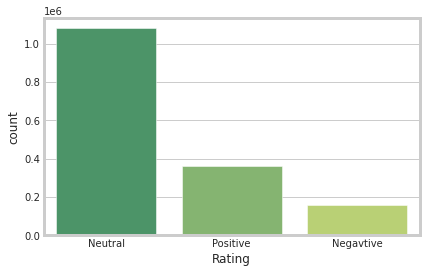

In [31]:
sns.set_style('whitegrid')
sns.countplot(x='Rating', data=tweet, palette='summer')

In [32]:
tweet = tweet.set_index('Date')

In [33]:
tweet.head()

,Review,Sentiment,Rating
Date,,,
2009-04-06 22:19:49,upset cant update Facebook texting might cry r...,0.000,Neutral
2009-04-06 22:19:53,Kenichan dived many times ball Managed save 50...,0.500,Positive
2009-04-06 22:19:57,whole body feels itchy like fire,0.200,Neutral
2009-04-06 22:19:57,nationwideclass behaving im mad cant see,-0.625,Negavtive
2009-04-06 22:20:00,Kwesidei whole crew,0.200,Neutral


In [ ]:
time = tweet[['Sentiment']].copy()

In [40]:
tweet.drop(['Sentiment'], axis=1, inplace=True)

In [41]:
one_hot = pd.get_dummies(tweet["Rating"])
tweet.drop(['Rating'],axis=1,inplace=True)
tweet = pd.concat([tweet,one_hot],axis=1)
tweet.head()

,Review,Negavtive,Neutral,Positive
Date,,,,
2009-04-06 22:19:49,upset cant update Facebook texting might cry r...,False,True,False
2009-04-06 22:19:53,Kenichan dived many times ball Managed save 50...,False,False,True
2009-04-06 22:19:57,whole body feels itchy like fire,False,True,False
2009-04-06 22:19:57,nationwideclass behaving im mad cant see,True,False,False
2009-04-06 22:20:00,Kwesidei whole crew,False,True,False


In [42]:
tweet.reset_index(drop=True, inplace=True)

In [43]:
tweet['Negavtive'] = tweet['Negavtive'].astype(int)
tweet['Neutral'] = tweet['Neutral'].astype(int)
tweet['Positive'] = tweet['Positive'].astype(int)

In [44]:
tweet.shape

(1599999, 4)

In [45]:
tweet.head()

,Review,Negavtive,Neutral,Positive
0,upset cant update Facebook texting might cry r...,0,1,0
1,Kenichan dived many times ball Managed save 50...,0,0,1
2,whole body feels itchy like fire,0,1,0
3,nationwideclass behaving im mad cant see,1,0,0
4,Kwesidei whole crew,0,1,0


In [46]:
from sklearn.model_selection import train_test_split
X = tweet['Review'].values
y = tweet.drop('Review', axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [47]:
X_train

array(['kaseey im process cutting stuff wall collage haha youre done wanna see picture',
       'Already work hour woe', 'Writing essay college writing boring',
       ...,
       'SarahFTW know sometimes pretend superpower like say something true would awesome power',
       'Cant believe came asked', 'back bali'], dtype=object)

In [65]:
y_train

array([[0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0]])

In [48]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
X_train_vect = vect.fit_transform(X_train)
X_test_vect = vect.transform(X_test)

In [66]:
#dont implement!!!!!!!
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_words = 10000 
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_train_padded = pad_sequences(X_train_sequences)
X_test_padded = pad_sequences(X_test_sequences, 
                              maxlen=X_train_padded.shape[1])

#encoder = OneHotEncoder(sparse=False)
#y_train_encoded = encoder.fit_transform(y_train)
#y_test_encoded = encoder.transform(y_test)

model = Sequential()
model.add(Embedding(input_dim=max_words, 
                    output_dim=32, 
                    input_length=X_train_padded.shape[1]))
model.add(LSTM(100))
model.add(Dense(3, activation='softmax')) 

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train_padded, y_train, 
          epochs=10, batch_size=256, 
          validation_data=(X_test_padded, y_test))

Epoch 1/10
4375/4375 [==============================] - 578s 132ms/step - loss: 0.1222 - accuracy: 0.9578 - val_loss: 0.0608 - val_accuracy: 0.9825
Epoch 2/10
4375/4375 [==============================] - 548s 125ms/step - loss: 0.0504 - accuracy: 0.9861 - val_loss: 0.0472 - val_accuracy: 0.9872
Epoch 3/10
4375/4375 [==============================] - 508s 116ms/step - loss: 0.0389 - accuracy: 0.9898 - val_loss: 0.0399 - val_accuracy: 0.9899
Epoch 4/10
4375/4375 [==============================] - 481s 110ms/step - loss: 0.0328 - accuracy: 0.9917 - val_loss: 0.0389 - val_accuracy: 0.9904
Epoch 5/10
4375/4375 [==============================] - 506s 116ms/step - loss: 0.0283 - accuracy: 0.9929 - val_loss: 0.0388 - val_accuracy: 0.9910
Epoch 6/10
4375/4375 [==============================] - 495s 113ms/step - loss: 0.0247 - accuracy: 0.9938 - val_loss: 0.0423 - val_accuracy: 0.9902
Epoch 7/10
4375/4375 [==============================] - 495s 113ms/step - loss: 0.0215 - accuracy: 0.9945 - val_

In [67]:
model_score = model.evaluate(X_test_padded, y_test, 
                             batch_size=64, verbose=1)
print('Test accuracy:', model_score[1])

7500/7500 [==============================] - 114s 15ms/step - loss: 0.0489 - accuracy: 0.9897
Test accuracy: 0.9897395968437195


In [68]:
preds = model.predict(X_test_padded)
preds

15000/15000 [==============================] - 108s 7ms/step


array([[4.62804316e-03, 9.95361805e-01, 1.00503139e-05],
       [6.18710692e-05, 9.99828815e-01, 1.09393906e-04],
       [1.43442258e-10, 1.13301921e-05, 9.99988616e-01],
       ...,
       [2.53839345e-11, 5.98701149e-07, 9.99999344e-01],
       [9.42088187e-01, 5.79117648e-02, 1.37244607e-08],
       [9.82800952e-09, 5.08274941e-04, 9.99491632e-01]], dtype=float32)

In [69]:
preds.shape

(480000, 3)

## Time Series Analysis

In [70]:
time.reset_index(inplace=True)

In [71]:
time = time.set_index('Date')

In [72]:
time.head()

,Sentiment
Date,
2009-04-06 22:19:49,0.000
2009-04-06 22:19:53,0.500
2009-04-06 22:19:57,0.200
2009-04-06 22:19:57,-0.625
2009-04-06 22:20:00,0.200


In [77]:
time.index = pd.to_datetime(time.index)
dtime = time.resample('D').mean().reset_index()

In [78]:
dtime

,Date,Sentiment
0,2009-04-06,0.093988
1,2009-04-07,0.099391
2,2009-04-08,NaN
3,2009-04-09,NaN
4,2009-04-10,NaN
...,...,...
76,2009-06-21,0.003373
77,2009-06-22,-0.024647
78,2009-06-23,-0.016030
79,2009-06-24,-0.014245


In [79]:
print(dtime.isnull().sum())

Date          0
Sentiment    33
dtype: int64


In [80]:
time_linear_interpolation = dtime.interpolate(method='linear')

In [81]:
dtime.interpolate(method='linear', inplace=True)

In [82]:
dtime

,Date,Sentiment
0,2009-04-06,0.093988
1,2009-04-07,0.099391
2,2009-04-08,0.101622
3,2009-04-09,0.103854
4,2009-04-10,0.106085
...,...,...
76,2009-06-21,0.003373
77,2009-06-22,-0.024647
78,2009-06-23,-0.016030
79,2009-06-24,-0.014245


In [83]:
print(dtime.isnull().sum())

Date         0
Sentiment    0
dtype: int64


In [84]:
dtime = dtime.set_index('Date')

In [85]:
(dtime.index == pd.date_range(start=dtime.index.min(),
                             end=dtime.index.max(),
                             freq=dtime.index.freq)).all()

True

Train dates : 2009-04-06 00:00:00 --- 2009-06-10 00:00:00  (n=66)
Test dates  : 2009-06-11 00:00:00 --- 2009-06-25 00:00:00  (n=15)


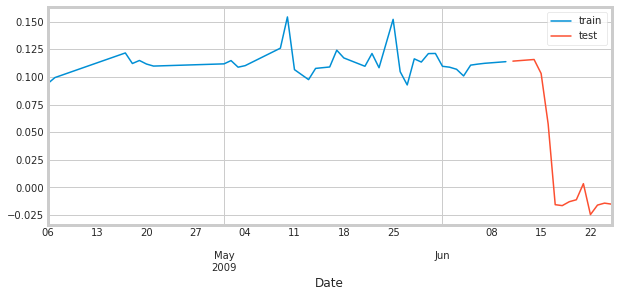

In [86]:
steps = 15
dtime_train = dtime[:-steps]
dtime_test  = dtime[-steps:]

print(f"Train dates : {dtime_train.index.min()} --- {dtime_train.index.max()}  (n={len(dtime_train)})")
print(f"Test dates  : {dtime_test.index.min()} --- {dtime_test.index.max()}  (n={len(dtime_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
dtime_train['Sentiment'].plot(ax=ax, label='train')
dtime_test['Sentiment'].plot(ax=ax, label='test')
ax.legend();

In [87]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 6
                )

forecaster.fit(y=dtime_train['Sentiment'])
forecaster

/home/hduser/.local/lib/python3.10/site-packages/skforecast/utils/utils.py:788: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/home/hduser/.local/lib/python3.10/site-packages/skforecast/utils/utils.py:788: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 65] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2023-11-15 23:43:11 
Last fit date: 2023-11-15 23:43:11 
Skforecast version: 0.10.1 
Python version: 3.10.12 
Forecaster id: None 

In [88]:
steps = 15
predictions = forecaster.predict(steps=steps)
predictions.head(5)

/home/hduser/.local/lib/python3.10/site-packages/skforecast/utils/utils.py:850: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


6     0.115862
7     0.117686
8     0.119138
9     0.119190
10    0.115782
Name: pred, dtype: float64

In [90]:
print(dtime_train.index)
print(dtime_test.index)
print(predictions.index)

DatetimeIndex(['2009-04-06', '2009-04-07', '2009-04-08', '2009-04-09',
               '2009-04-10', '2009-04-11', '2009-04-12', '2009-04-13',
               '2009-04-14', '2009-04-15', '2009-04-16', '2009-04-17',
               '2009-04-18', '2009-04-19', '2009-04-20', '2009-04-21',
               '2009-04-22', '2009-04-23', '2009-04-24', '2009-04-25',
               '2009-04-26', '2009-04-27', '2009-04-28', '2009-04-29',
               '2009-04-30', '2009-05-01', '2009-05-02', '2009-05-03',
               '2009-05-04', '2009-05-05', '2009-05-06', '2009-05-07',
               '2009-05-08', '2009-05-09', '2009-05-10', '2009-05-11',
               '2009-05-12', '2009-05-13', '2009-05-14', '2009-05-15',
               '2009-05-16', '2009-05-17', '2009-05-18', '2009-05-19',
               '2009-05-20', '2009-05-21', '2009-05-22', '2009-05-23',
               '2009-05-24', '2009-05-25', '2009-05-26', '2009-05-27',
               '2009-05-28', '2009-05-29', '2009-05-30', '2009-05-31',
      

In [91]:
dtime_train.index = pd.to_datetime(dtime_train.index)
dtime_test.index = pd.to_datetime(dtime_test.index)
predictions.index = pd.to_datetime(predictions.index)

In [95]:
predictions

1970-01-01 00:00:00.000000006    0.115862
1970-01-01 00:00:00.000000007    0.117686
1970-01-01 00:00:00.000000008    0.119138
1970-01-01 00:00:00.000000009    0.119190
1970-01-01 00:00:00.000000010    0.115782
1970-01-01 00:00:00.000000011    0.114500
1970-01-01 00:00:00.000000012    0.114162
1970-01-01 00:00:00.000000013    0.112821
1970-01-01 00:00:00.000000014    0.113877
1970-01-01 00:00:00.000000015    0.113683
1970-01-01 00:00:00.000000016    0.115776
1970-01-01 00:00:00.000000017    0.118226
1970-01-01 00:00:00.000000018    0.119280
1970-01-01 00:00:00.000000019    0.119661
1970-01-01 00:00:00.000000020    0.115901
Name: pred, dtype: float64

In [96]:
predictions.reset_index(drop=True, inplace=True)  
predictions.index = pd.date_range(start='2009-06-11', periods=len(predictions))  

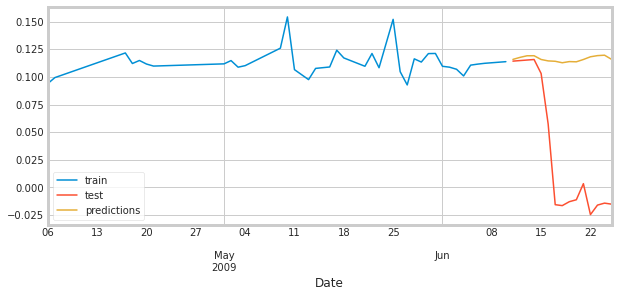

In [98]:
#fig, ax = plt.subplots(figsize=(9, 4))
#dtime_train['Sentiment'].plot(ax=ax, label='train')
#dtime_test['Sentiment'].plot(ax=ax, label='test')
#predictions.plot(ax=ax, label='predictions')
#ax.legend();

fig, ax = plt.subplots(figsize=(9, 4))
dtime_train['Sentiment'].plot(ax=ax, label='train', x=dtime_train.index.tolist())
dtime_test['Sentiment'].plot(ax=ax, label='test', x=dtime_test.index.tolist())
predictions.plot(ax=ax, label='predictions', x=predictions.index.tolist())
ax.legend();

In [99]:
error_mse = mean_squared_error(
                y_true = dtime_test['Sentiment'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 0.010346302226309632


In [100]:
steps = 15
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12)

lags_grid = [10, 20]

param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = dtime_train['Sentiment'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(dtime_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False)

Number of models compared: 12.


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


AttributeError: 'FloatProgress' object has no attribute 'style'

In [103]:
#pip install sktime

In [106]:
#pip install --upgrade sktime

In [108]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_squared_error
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.forecasting.ensemble import RandomForestForecaster
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer
from sktime.transformations.series.boxcox import BoxCoxTransformer

# Assuming you have a time series in the 'dtime_train' DataFrame
y_train = dtime_train['Sentiment']

# Define the forecaster with a RandomForestRegressor as the regressor
forecaster = TransformedTargetForecaster(
    forecaster=RandomForestForecaster(random_state=123),
    transformer=Deseasonalizer(model='multiplicative', sp=12) + BoxCoxTransformer()
)

# Define the parameter grid for the grid search
param_grid = {
    "forecaster__n_estimators": [100, 500],
    "forecaster__max_depth": [3, 5, 10],
    "forecaster__min_samples_split": [2, 5, 10],
    "forecaster__min_samples_leaf": [1, 2, 4],
}

# Perform temporal train-test split
y_train, y_test = temporal_train_test_split(y_train, test_size=steps)

# Set up the grid search
grid_search = ForecastingGridSearchCV(
    forecaster, param_grid, cv=3, scoring="neg_mean_squared_error", verbose=2
)

# Fit the grid search to find the best hyperparameters
grid_search.fit(y_train)

# Get the best forecaster
best_forecaster = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_forecaster.predict(fh=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])

# Calculate mean squared error on the test set
mse = mean_squared_error(y_test, y_pred)
print(f"Test Mean Squared Error: {mse}")

ModuleNotFoundError: No module named 'sktime.forecasting.ensemble'